In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

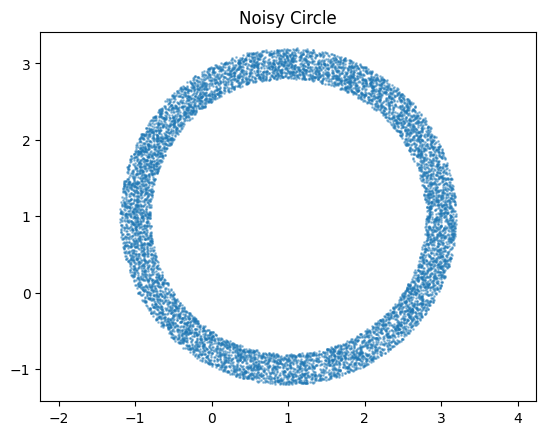

In [3]:

def make_data(center, radius, size, width):
    # Uniform angle around the circle
    theta = np.random.uniform(0, 2 * np.pi, size)

    # Add radial noise (the "wiggle")
    r = radius + np.random.uniform(-width, width, size)

    # Convert polar to cartesian
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)

    return x.astype(np.float32), y.astype(np.float32)

# Example usage
x, y = make_data(center=(1, 1), radius=2, size=10_000, width=0.2)

plt.scatter(x, y, alpha=0.4, s=1)
plt.axis("equal")
plt.title("Noisy Circle")
plt.show()


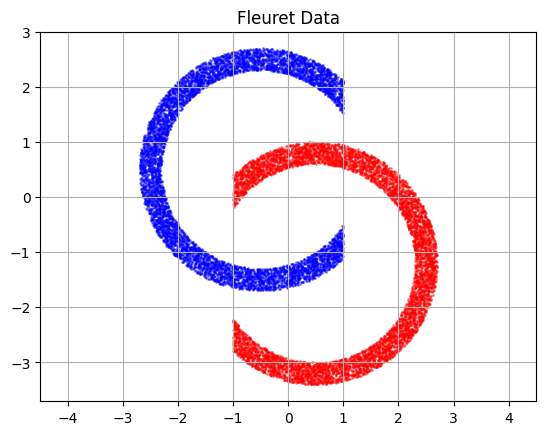

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage
left = make_data(center=(-.5, .5), radius=2, size=10_000, width=0.2)
right = make_data(center=(.5, -1.2), radius=2, size=10_000, width=0.2)

x_left = left[0]
y_left = left[1]
x_right = right[0]
y_right = right[1]

x_blue = x_left[x_left < 1]
y_blue = y_left[x_left < 1]
x_red = x_right[x_right > -1]
y_red = y_right[x_right > -1]

s = min(x_blue.shape, x_red.shape)[0]
x_blue = x_blue[:s]
y_blue = y_blue[:s]
x_red = x_red[:s]
y_red = y_red[:s]

plt.scatter(x_blue, y_blue, alpha=0.4, s=1, color='blue')
plt.scatter(x_red, y_red, alpha=0.4, s=1, color='red')
plt.axis("equal")
plt.title("Fleuret Data")
plt.grid()
plt.show()


In [5]:
xs = torch.concat([torch.tensor(x_blue), torch.tensor(x_red)]).reshape(-1,1)
ys = torch.concat([torch.tensor(y_blue), torch.tensor(y_red)]).reshape(-1,1)

Xs = torch.concat([xs, ys], axis=1)
target = torch.concat([torch.ones(len(x_red)), torch.zeros(len(x_red))])

Xs.shape, target.shape

(torch.Size([15374, 2]), torch.Size([15374]))

In [6]:
mean = Xs.mean(axis=0)       # shape (2,)
std = Xs.std(axis=0)         # shape (2,)
X_norm = (Xs - mean) / std

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, target)

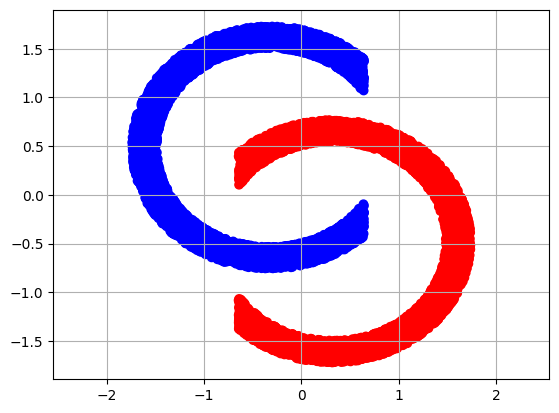

In [8]:
colors = ['red' if y.item() == 0 else 'blue' for y in y_train]
plt.scatter(X_train[:,0], X_train[:,1], color=colors);
plt.axis("equal");
plt.grid();


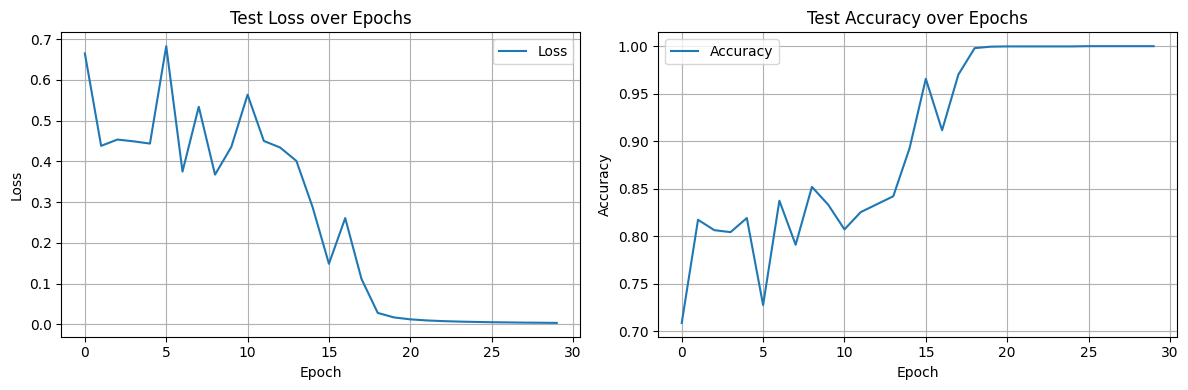

In [59]:
# 1. Model Definition
depth = 8
hidden_size = 4

class MyModel(nn.Module):
    def __init__(self, fleuret=False, depth=depth, hidden_size=hidden_size):
        super().__init__()
        if fleuret:
            layers = []
            layers.append(nn.Linear(2, hidden_size))
            layers.append(nn.Tanh())
            for _ in range(depth):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.Tanh())

            layers.append(nn.Linear(hidden_size, 1))

            self.net = nn.Sequential(*layers)

        else:
            self.net = nn.Sequential(
                nn.Linear(2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2),
                nn.Tanh(),
                nn.Linear(2, 1)
            )

    def forward(self, x):
        return self.net(x)

# 2. Gradient Norm Printer
def print_grad_norms(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            norm = param.grad.data.norm().item()
            print(f"grad norm {name}: {norm:.6e}")

# 3. Data Generation
np.random.seed(42)
torch.manual_seed(42)

# 4. Model & Optimizer
model = MyModel(fleuret=False, depth=8, hidden_size=3)
loss_fn = nn.BCEWithLogitsLoss()

batch_size = 2048
learning_rate = 2
epochs = 30
num_to_show = 10
step = epochs // num_to_show

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 5. Training
tic = time.perf_counter()

intermediate_results = []

losses = []
accuracies = []

# 6. Data mesh
a = torch.arange(-3,3,.5)
b = torch.arange(-3,3,.5)
aa, bb = torch.meshgrid(a, b, indexing='ij')

cartesian_torch = torch.stack([aa.ravel(), bb.ravel()], dim=1)

for e in range(epochs):
    perm = torch.randperm(len(X_train))
    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

    # Evaluation
    with torch.no_grad():
        logits = model(X_test).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        acc = (preds == y_test).float().mean().item()
        loss_val = loss_fn(logits, y_test).item()

        losses.append(loss_val)
        accuracies.append(acc)

        if e % step == 0 or e == epochs - 1 or e <= 10:
            intermediate_results.append((e, 
                                         preds, 
                                         model.net[:-2](X_test), 
                                         y_test, 
                                         model.net[:-2](cartesian_torch)))

    toc = time.perf_counter()
    # print(f"Epoch {e}: Test accuracy {acc:.3f}, Loss: {loss_val:.3f}, Time: {toc - tic:.3f} (s)")

# Plot loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(losses, label='Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Test Loss over Epochs')
axs[0].grid()
axs[0].legend()

axs[1].plot(accuracies, label='Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Test Accuracy over Epochs')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


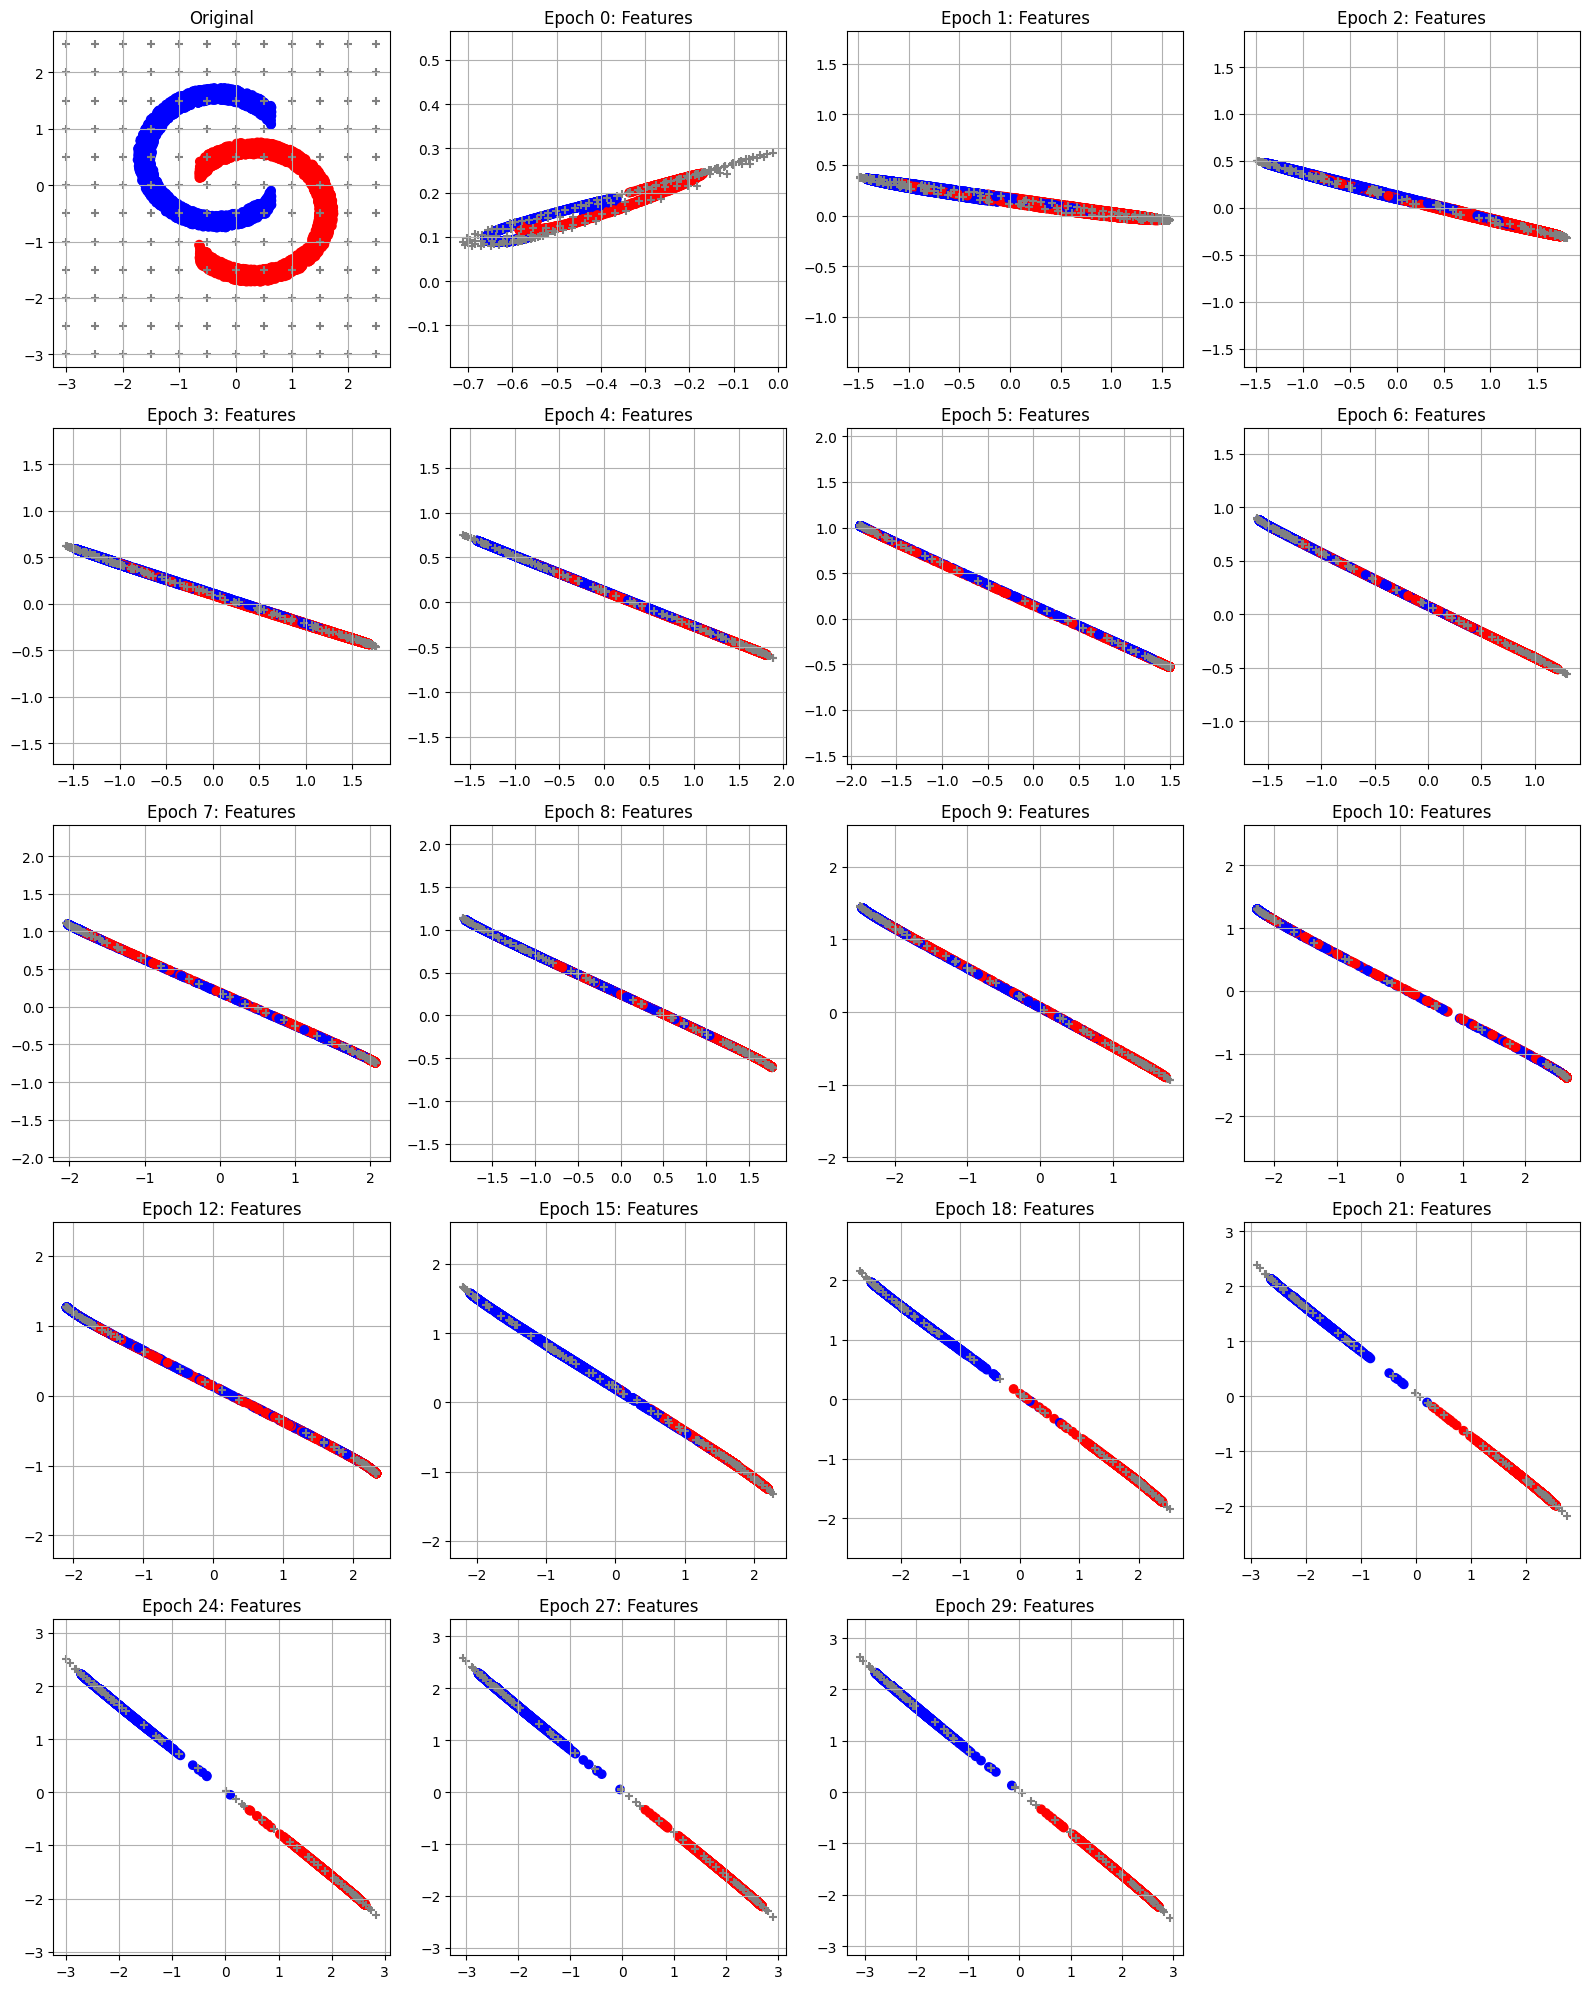

In [60]:
n_plots = len(intermediate_results) + 1
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Original test set
ax = axes[0]
colors = ['red' if y.item() == 0 else 'blue' for y in y_test]
ax.scatter(X_test[:,0], X_test[:,1], color=colors)
ax.scatter(cartesian_torch[:,0], cartesian_torch[:,1], marker='+', color='gray')
ax.set_axis_on()
ax.set_title("Original")
ax.axis("equal")
ax.grid()

# Intermediate results
for i, r in enumerate(intermediate_results):
    ax = axes[i+1]
    colors = ['red' if y == 0 else 'blue' for y in r[3]]
    ax.scatter(r[2][:,0], r[2][:,1], color=colors)
    ax.scatter(r[4][:,0], r[4][:,1], marker='+', color='gray')
    ax.set_axis_on()
    ax.set_title(f"Epoch {r[0]}: Features")
    ax.axis("equal")
    ax.grid()


# Hide unused axes
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

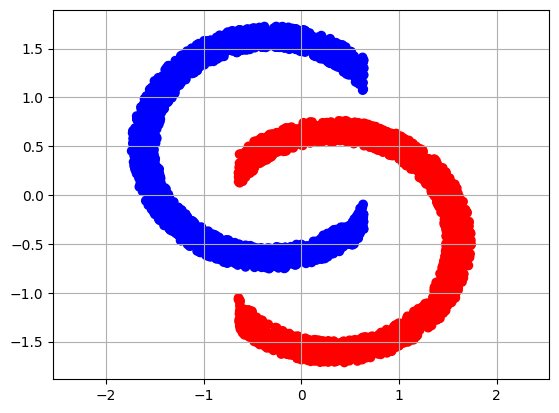

In [61]:
colors = ['red' if y == 0 else 'blue' for y in preds]
plt.scatter(X_test[:,0], X_test[:,1], color=colors);
plt.axis("equal");
plt.grid();

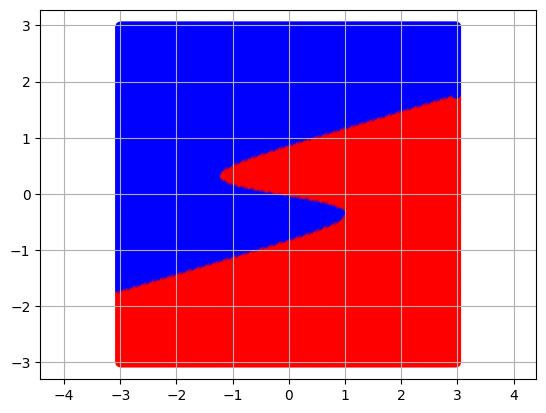

In [27]:
a = torch.arange(-3,3,0.02)
b = torch.arange(-3,3,0.02)
aa, bb = torch.meshgrid(a, b, indexing='ij')

cartesian_torch = torch.stack([aa.ravel(), bb.ravel()], dim=1)

with torch.no_grad():
    logits = model(cartesian_torch)
    probs = torch.sigmoid(logits).squeeze()
    preds = (probs > 0.5).int()

colors = ['red' if y == 0 else 'blue' for y in preds]
plt.scatter(cartesian_torch[:,0], cartesian_torch[:,1], color=colors)
plt.axis("equal")
plt.grid()
